# 36 Oph photometry

36 Oph is a 5th magnitude triple star system of three K dwarfs. The primary and secondary were observed in short and long cadence during K2 Campaign 11 through a 'halo photometry' circular mask with a diameter of 30 pixels.

From the data release notes:
    
>Campaign 11 was operationally separated into two segments as a result of an error in the initial roll-angle used to minimize solar torque on the spacecraft. The larger than expected roll motion seen at the start of the campaign meant that the targets would be rolling out of their pixel apertures by the end of the campaign. The excess roll motion was corrected twenty-three days into the campaign by applying a -0.32º roll offset. The size of this correction meant that new target aperture definitions had to be used for the second part of the campaign. The two segments are identified in the archive products as C111 and C112, respectively.

As a result, the data sets for 36 Oph have two different K2 IDs that need to be used to find the data on MAST.

K2 IDs:	200129035 (C111)
            200147465 (C112)

Both short cadence and long cadence exist.

Target pixel files:

	ktwo200129035-c111_lpd-targ.fits.gz 15M
	ktwo200147465-c112_lpd-targ.fits.gz 31M
    ktwo200129035-c111_spd-targ.fits.gz 421M
	ktwo200147465-c112_spd-targ.fits.gz 874M

Let's start with the long cadence first.

Here is the image of the target mask from C111:
<img src="36_Oph_C111_fluxmap_o1_sub1.png" alt="36 Oph flux map from C111" title="36 Oph in C111" />

And here is the image from C112:
<img src="36_Oph_C112_fluxmap_o1_sub1.png" alt="36 Oph flux map from C112" title="36 Oph in C112" />

They look almost the same, and 36 Oph is not quite centred. There's a number of background stars present, one or two are along the flux bleed column from 36 Oph. But can 36 Oph A and B be distinguished?

The Washington Double Star Catalog gives a separation of 36 Oph A and B of 5.4 arcsec in 2016. C11 ran from 2016 Sept to Dec. Given the _Kepler_ pixel size of 3.96x3.96 arcsec, 36 Oph A and B would be on adjacent pixels. They cannot be visually distinguished in K2 photometry. But perhaps they can be distininguished in their power spectra.

36 Oph C is at a separation of ~732 arcseconds, and is therefore well outside the mask. Unfortunately, it appears it was just off the edge of CCD 17 and went unobserved.

### Halo photometry
Light curves were prepared using the halo photometry method, asigning a weight to each pixel to minimize the total variation of the light curve and thereby remove the spacecraft drift signal (White et al. 2017). 

For later reference, the code was called from the command line:
```
> halo -c 11 --do-plot --name 36_Oph_C111 ktwo200129035-c111_lpd-targ.fits.gz
> halo -c 11 --do-plot --name 36_Oph_C112 ktwo200147465-c112_lpd-targ.fits.gz
```
and produced the fits files:
```
36_Oph_C111halo_lc_o1.fits
36_Oph_C112halo_lc_o1.fits
```

These are the weight maps:
<img src="36_Oph_C111_weightmap_o1_sub1.png" alt="36 Oph flux map from C111" title="36 Oph weights in C111" />
<img src="36_Oph_C112_weightmap_o1_sub1.png" alt="36 Oph flux map from C112" title="36 Oph weights in C112" />
Red pixels have been upweighted, and blue pixels have been downweighted. Some of the background stars have been upweighted, but so too has 36 Oph, and most of the flux comes from this system.

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special as sp
import plotly.plotly as py
from plotly.graph_objs import *
from astropy.io import fits
from astropy.stats import LombScargle
from scipy.signal import savgol_filter

In [2]:
filename='36_Oph_C111halo_lc_o1.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    
ts1 = data.field('TIME')
fs1 = data.field('CORR_FLUX')/np.median(data.field('CORR_FLUX'))

filename='36_Oph_C112halo_lc_o1.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    
ts2 = data.field('TIME')
fs2 = data.field('CORR_FLUX')/np.median(data.field('CORR_FLUX'))


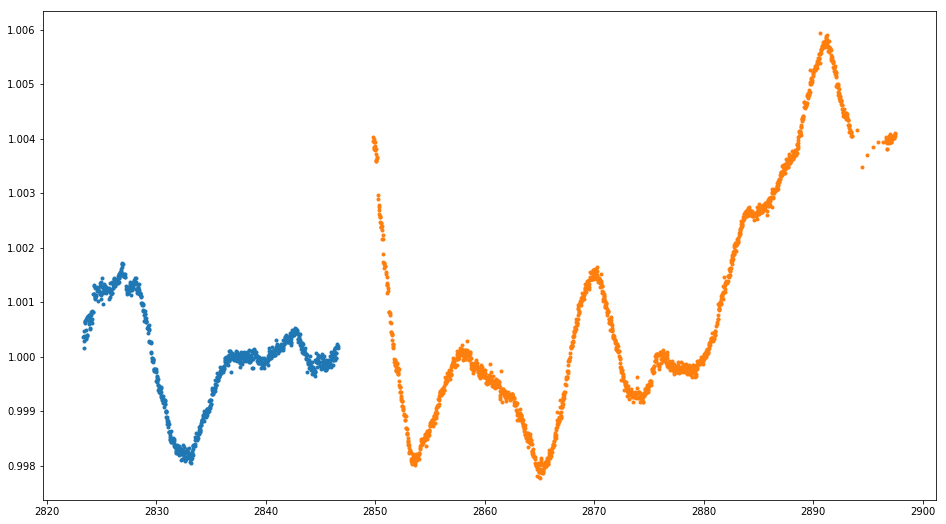

In [3]:
fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1,'.')
plt.plot(ts2,fs2,'.')

plt.show()

The first couple of days of C112 show a trend that is probably instrumental. The last bit isn't great either, so for now lets just cut those bits out. Additionally, remove the long term trends that may or may not be instrumental.

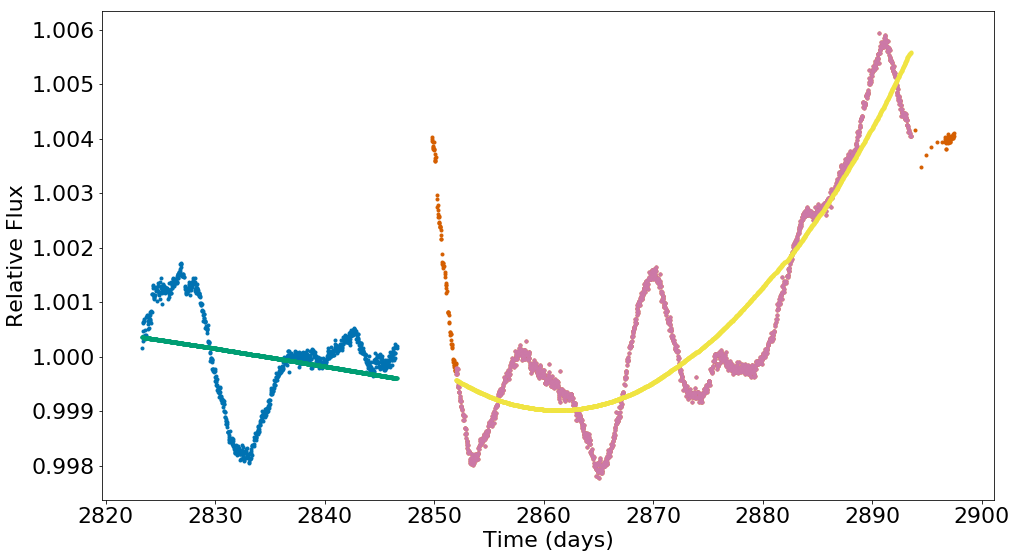

In [4]:
cts2 = [] #cut time C112
cfs2 = [] #cut flux C112

for t,f in zip(ts2,fs2):
    if t > 2852 and t < 2893.7:
        cts2=np.append(cts2,t)
        cfs2=np.append(cfs2,f)

ys1 = savgol_filter(fs1,983,1) #983 = length of segment 1
ys2 = savgol_filter(cfs2,1733,2) #1733 = length of segment 2

ts = np.append(ts1,cts2)
fs = np.append(fs1/ys1,cfs2/ys2)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))


fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1,'.')
#plt.plot(cts1,cfs1,'.')
#plt.plot(cts1,ys1,'.')
plt.plot(ts1,ys1,'.')
plt.plot(ts2,fs2,'.')
plt.plot(cts2,cfs2,'.')
plt.plot(cts2,ys2,'.')
#plt.plot(ts,fs,'.')

plt.xlabel('Time (days)', fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.show()

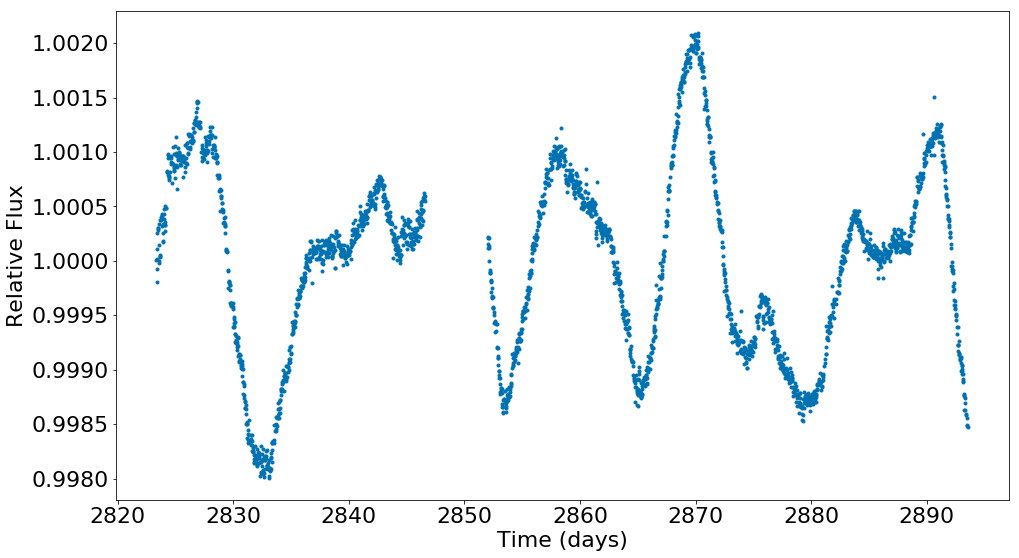

In [5]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))


fig = plt.figure(figsize=(16,9))
plt.plot(ts,fs,'.')

plt.xlabel('Time (days)', fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.show()

In [6]:
frequency, power = LombScargle(ts, fs).autopower(samples_per_peak=20)

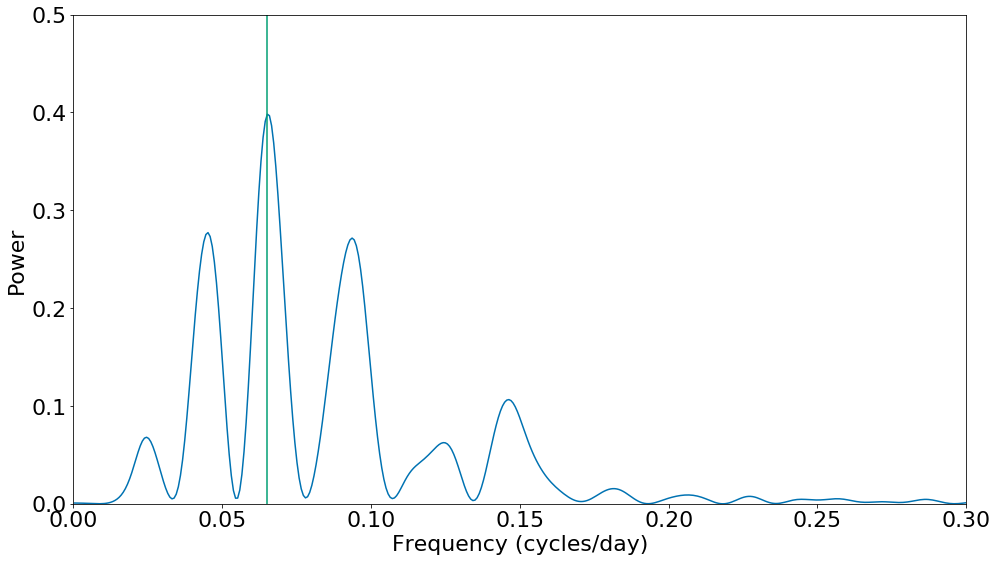

In [7]:
fig = plt.figure(figsize=(16,9))
plt.plot(frequency,power)

plt.plot([0.065,0.065],[0,1])

plt.xlim([0,0.3])
plt.ylim([0,0.5])

plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power')

plt.show()

There are several low-frequency peaks that could be attributable to spot-induced rotational modulation in either 36 Oph A or 36 Oph B. No doubt investigating this properly would require a less dodgy processing of the light curve. Donahue, Saar & Baliunas (1996) give their periods as 20.96 and 21.11 days, for the A and B components respectively, which both correspond to the peak at ~0.045 d$^{-1}$. Based on those values, it doesn't appear as if the rotational periods of 36 Oph A and B can be distinguished from the K2 data in the frequency domain.

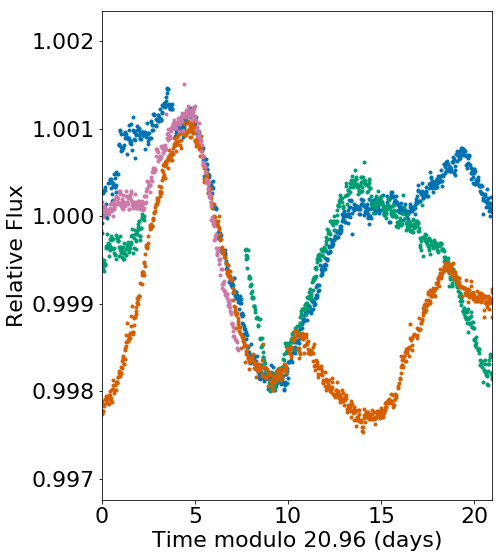

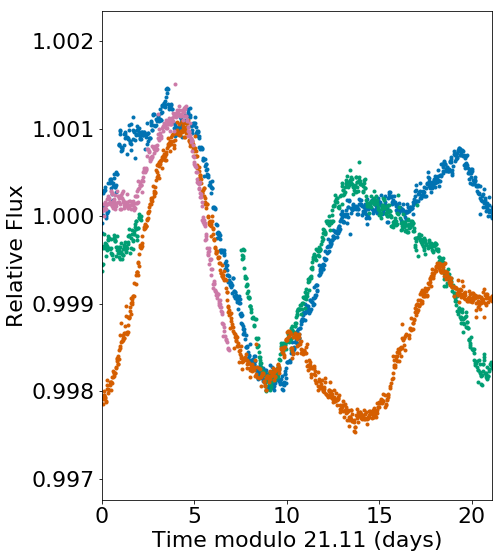

In [8]:
#period = 15.38
period = 20.96
#period = 16.4

fig = plt.figure(figsize=(7,9))
plt.plot(ts-ts[0],fs,'.')
plt.plot(ts-ts[0]-period,0.9994*fs,'.')
plt.plot(ts-ts[0]-period*2,0.9990*fs,'.')
plt.plot(ts-ts[0]-period*3,fs,'.')
# plt.plot(ts-ts[0]-period*4,fs,'.')
# plt.plot(ts-ts[0]-period*5,fs,'.')

plt.xlabel('Time modulo %.2f (days)' % period, fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.xlim([0,period])

plt.show()

period = 21.11

fig = plt.figure(figsize=(7,9))
plt.plot(ts-ts[0],fs,'.')
plt.plot(ts-ts[0]-period,0.9994*fs,'.')
plt.plot(ts-ts[0]-period*2,0.9990*fs,'.')
plt.plot(ts-ts[0]-period*3,fs,'.')

plt.xlabel('Time modulo %.2f (days)' % period, fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.xlim([0,period])

plt.show()

It would appear that one series of dips lines up well with being due to rotation of 36 Oph A. The other variability seems harder to explain as being from either component.

Anything worth looking at in the residuals once the rotational modulation is removed?

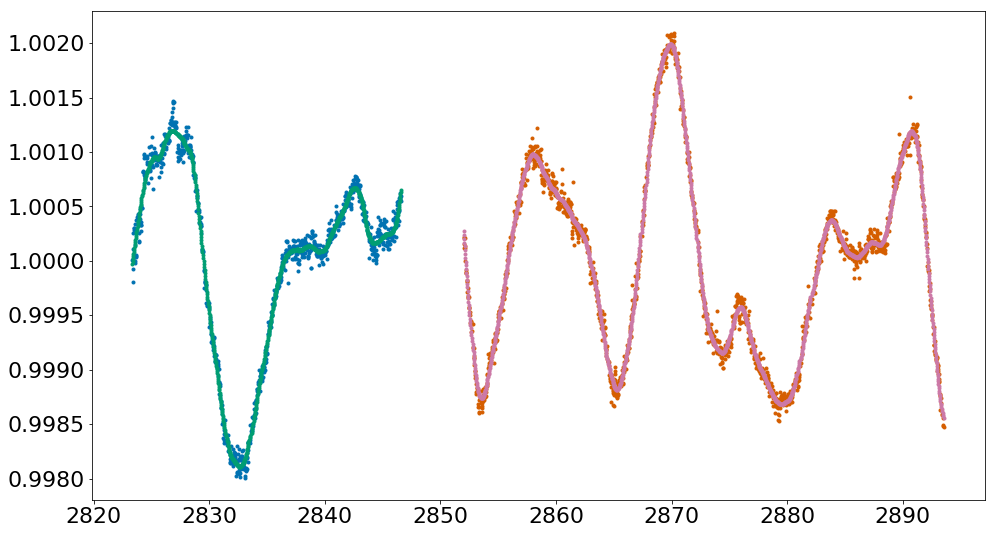

In [9]:
ys12 = savgol_filter(fs1/ys1,101,3)
ys22 = savgol_filter(cfs2/ys2,101,3)

fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1/ys1,'.')
plt.plot(ts1,ys12,'.')

plt.plot(cts2,cfs2/ys2,'.')
plt.plot(cts2,ys22,'.')

plt.show()



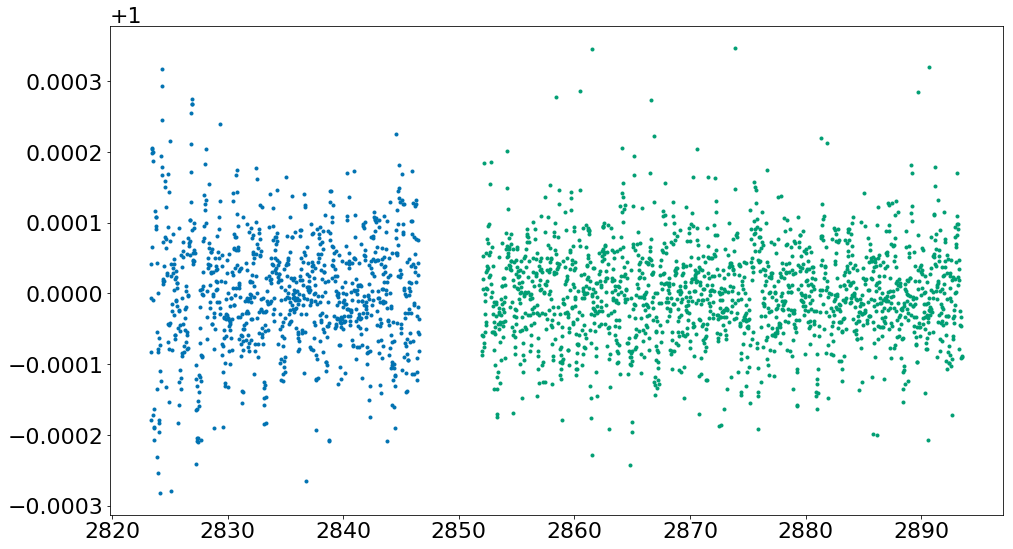

In [10]:
fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1/ys1/ys12,'.')
plt.plot(cts2,cfs2/ys2/ys22,'.')

plt.show()

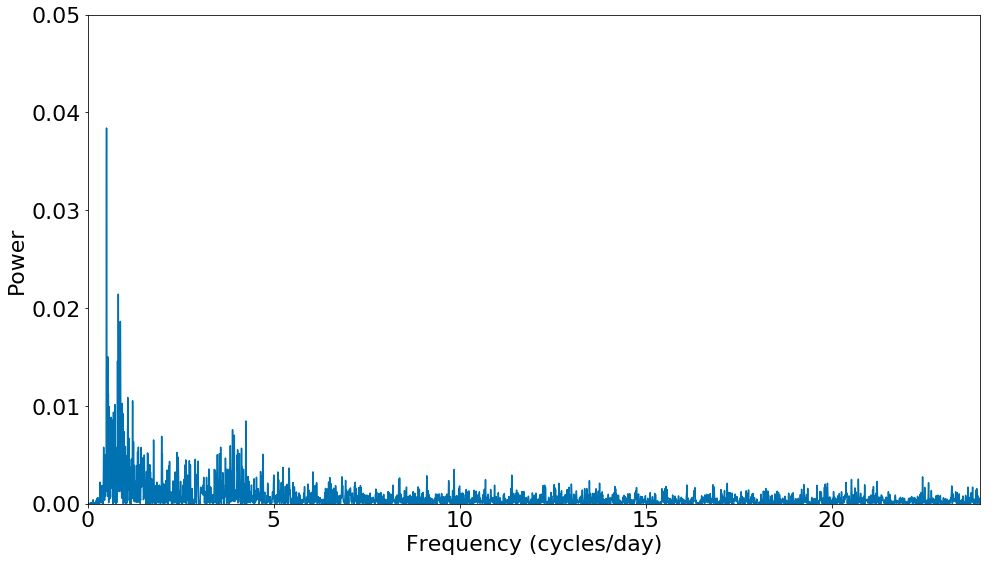

In [11]:
frequency, power = LombScargle(np.append(ts1,cts2), np.append(fs1/ys1/ys12,cfs2/ys2/ys22)).autopower(samples_per_peak=20)

fig = plt.figure(figsize=(16,9))
plt.plot(frequency,power)

plt.xlim([0,24])
plt.ylim([0,0.05])

plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power')

plt.show()

The group of peaks around 4 cycles/day is presumably an artifact of the thruster firing.

The short cadence still needs to be looked at.

## Separating 36 Oph A and B

36 Oph B is separated by 5.4 arcseconds from 36 Oph A, with a position angle of 143 degrees. 36 Oph C is 730 arcseconds away at a posiiton angle of 74 degrees. Mapping this onto the full-frame image, we find these position vectors from the primary to 36 Oph B (red) and C (blue):

<img src="36Oph.png" alt="36 Oph in the FFI" title="36 Oph in the FFI" />

36 Oph B is roughly one pixel row above 36 Oph A. 36 Oph C is confirmed to be well off the CCD, and no evidence of scattered light is found by visual inspection of the full frame image.

The spacecraft motion is predominently left to right. If we therefore restrict ourselves to including alternatively only the pixels below and above the centre of the image, we may be able to emphasise the signal of one over the other, while still obtaining a decent lightcurve from the halo algorithm.

Let's try from row 20 and above for 36 Oph B, and 17 and below for 36 Oph A.

For later reference, the code was called from the command line:
```
> halo -c 11 --do-plot --top 20 --name 36_Oph_C111_t ktwo200129035-c111_lpd-targ.fits.gz
> halo -c 11 --do-plot --top 20 --name 36_Oph_C112_t ktwo200147465-c112_lpd-targ.fits.gz
> halo -c 11 --do-plot --bottom 17 --name 36_Oph_C111_b ktwo200129035-c111_lpd-targ.fits.gz
> halo -c 11 --do-plot --bottom 17 --name 36_Oph_C112_b ktwo200147465-c112_lpd-targ.fits.gz
```
and produced the fits files:
```
36_Oph_C111_thalo_lc_o1.fits
36_Oph_C112_thalo_lc_o1.fits
36_Oph_C111_bhalo_lc_o1.fits
36_Oph_C112_bhalo_lc_o1.fits
```

These are the weight maps:
<img src="36_Oph_C111_t_weightmap_o1_sub1.png" alt="36 Oph flux map from C111" title="36 Oph weights in C111" style="width: 400px;"/>
<img src="36_Oph_C112_t_weightmap_o1_sub1.png" alt="36 Oph flux map from C112" title="36 Oph weights in C112"  style="width: 400px;"/>
<img src="36_Oph_C111_b_weightmap_o1_sub1.png" alt="36 Oph flux map from C111" title="36 Oph weights in C111" style="width: 400px;"/>
<img src="36_Oph_C112_b_weightmap_o1_sub1.png" alt="36 Oph flux map from C112" title="36 Oph weights in C112"  style="width: 400px;"/>

So, unfortunately, the weights don't look great. Let's see how the light curves compare.

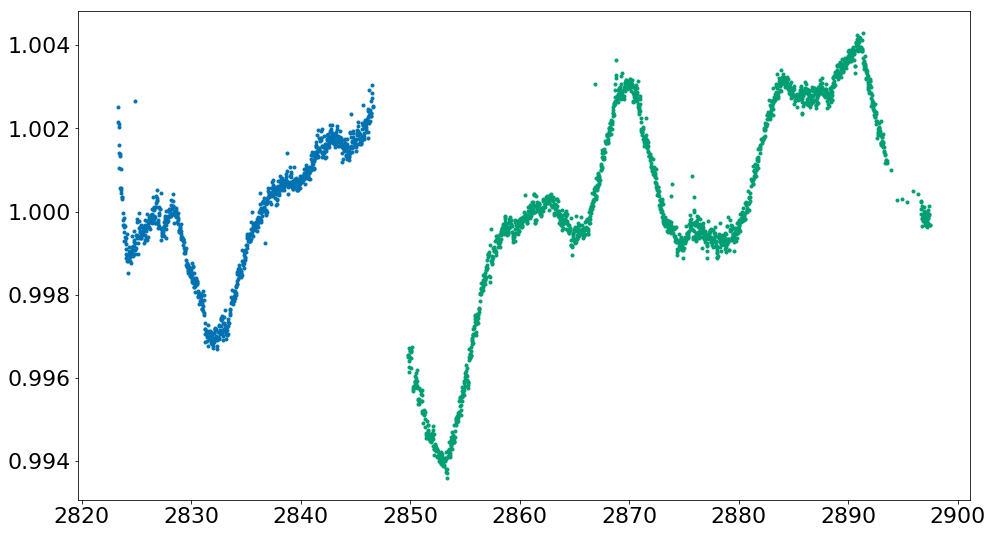

In [12]:
filename='36_Oph_C111_thalo_lc_o1.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    
ts1 = data.field('TIME')
fs1 = data.field('CORR_FLUX')/np.median(data.field('CORR_FLUX'))

filename='36_Oph_C112_thalo_lc_o1.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    
ts2 = data.field('TIME')
fs2 = data.field('CORR_FLUX')/np.median(data.field('CORR_FLUX'))

fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1,'.')
plt.plot(ts2,fs2,'.')

#plt.xlim([2823,2840])

plt.show()

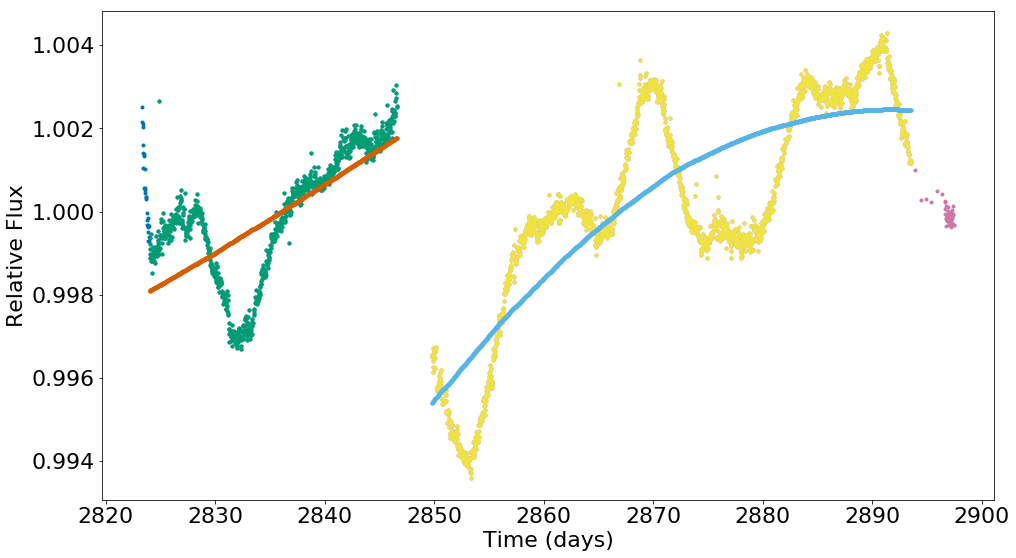

In [13]:
cts1 = [] #cut time C111
cfs1 = [] #cut flux C111

for t,f in zip(ts1,fs1):
    if t > 2824:
        cts1=np.append(cts1,t)
        cfs1=np.append(cfs1,f)

cts2 = [] #cut time C112
cfs2 = [] #cut flux C112

for t,f in zip(ts2,fs2):
    if t < 2893.7:
        cts2=np.append(cts2,t)
        cfs2=np.append(cfs2,f)

ys1 = savgol_filter(cfs1,951,1) #983 = length of segment 1
ys2 = savgol_filter(cfs2,1733,2) #1733 = length of segment 2

tsb = np.append(cts1,cts2)
fsb = np.append(cfs1/ys1,cfs2/ys2)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))


fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1,'.')
plt.plot(cts1,cfs1,'.')
plt.plot(cts1,ys1,'.')
plt.plot(ts2,fs2,'.')
plt.plot(cts2,cfs2,'.')
plt.plot(cts2,ys2,'.')
#plt.plot(ts,fs,'.')

plt.xlabel('Time (days)', fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.show()

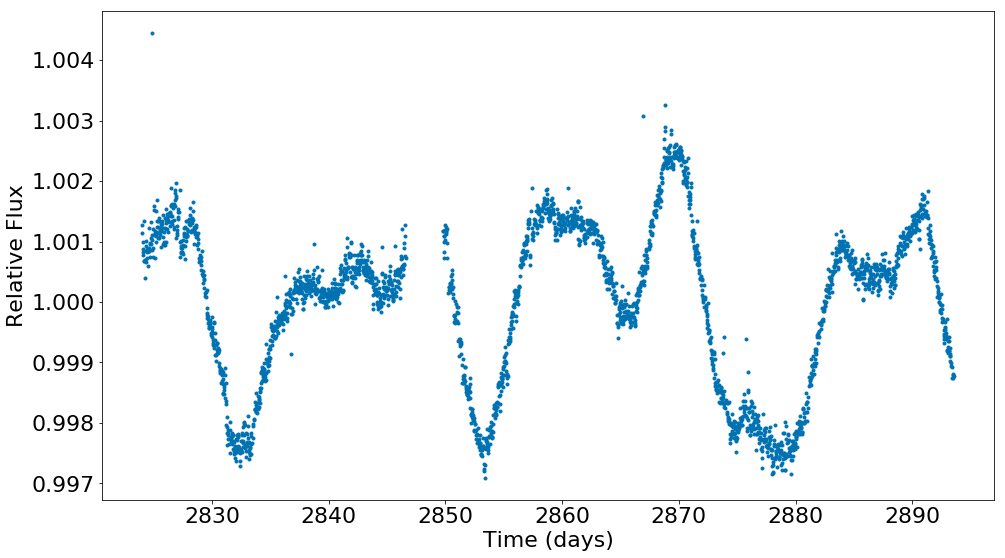

In [14]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))


fig = plt.figure(figsize=(16,9))
plt.plot(tsb,fsb,'.')

plt.xlabel('Time (days)', fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.show()

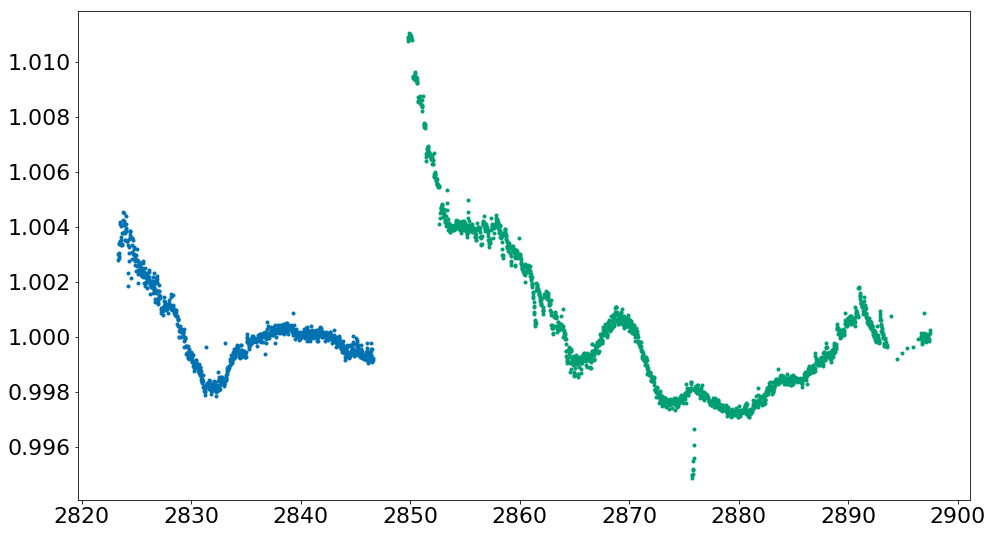

In [15]:
filename='36_Oph_C111_bhalo_lc_o1.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    
ts1 = data.field('TIME')
fs1 = data.field('CORR_FLUX')/np.median(data.field('CORR_FLUX'))

filename='36_Oph_C112_bhalo_lc_o1.fits'

with fits.open(filename) as hdul:
    data = hdul[1].data
    
ts2 = data.field('TIME')
fs2 = data.field('CORR_FLUX')/np.median(data.field('CORR_FLUX'))

fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1,'.')
plt.plot(ts2,fs2,'.')

plt.show()

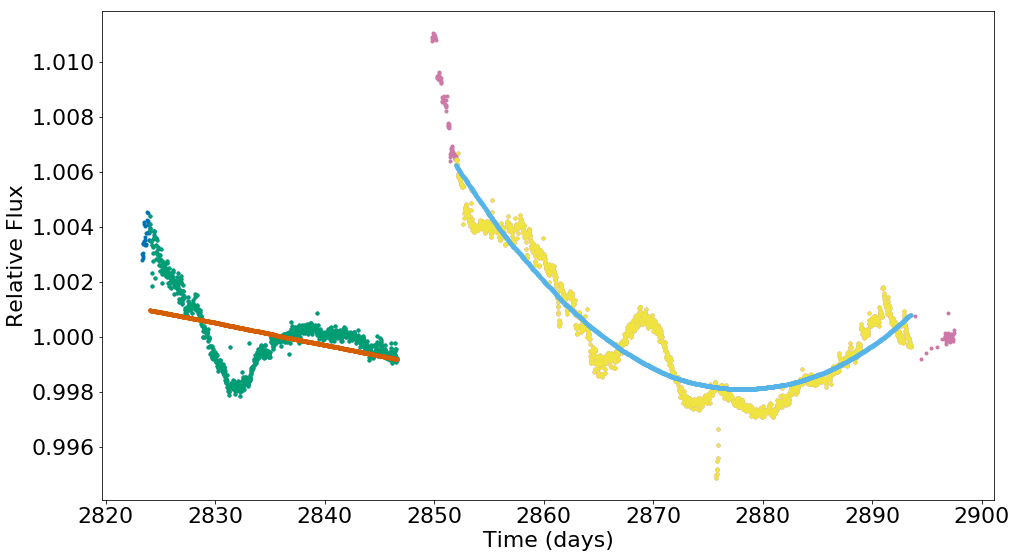

In [16]:
cts1 = [] #cut time C111
cfs1 = [] #cut flux C111

for t,f in zip(ts1,fs1):
    if t > 2824:
        cts1=np.append(cts1,t)
        cfs1=np.append(cfs1,f)

cts2 = [] #cut time C112
cfs2 = [] #cut flux C112

for t,f in zip(ts2,fs2):
    if t > 2852 and t < 2893.7:
        cts2=np.append(cts2,t)
        cfs2=np.append(cfs2,f)

ys1 = savgol_filter(cfs1,951,1) #983 = length of segment 1
ys2 = savgol_filter(cfs2,1733,2) #1733 = length of segment 2

tsa = np.append(cts1,cts2)
fsa = np.append(cfs1/ys1,cfs2/ys2)

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))


fig = plt.figure(figsize=(16,9))
plt.plot(ts1,fs1,'.')
plt.plot(cts1,cfs1,'.')
plt.plot(cts1,ys1,'.')
plt.plot(ts2,fs2,'.')
plt.plot(cts2,cfs2,'.')
plt.plot(cts2,ys2,'.')
#plt.plot(ts,fs,'.')

plt.xlabel('Time (days)', fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.show()

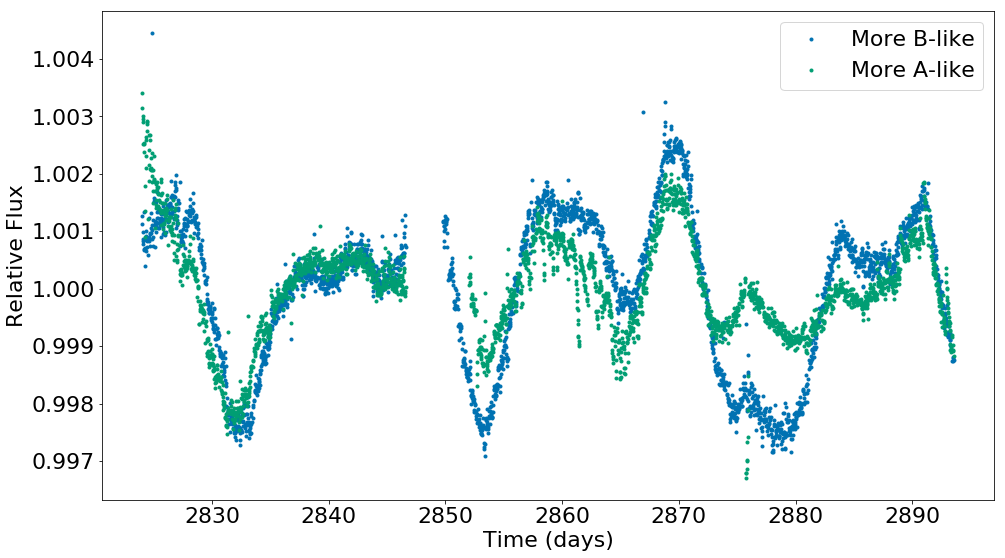

In [17]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 22,
        }

matplotlib.rc('font', **font)
sns.set_palette(sns.color_palette("colorblind"))


fig = plt.figure(figsize=(16,9))
plt.plot(tsb,fsb,'.',label='More B-like')
plt.plot(tsa,fsa,'.',label='More A-like')

plt.xlabel('Time (days)', fontdict=font)
plt.ylabel('Relative Flux', fontdict=font)

plt.legend()

plt.show()

So um... I don't think this really shows anything. Differences are more influence by the long-term correction that I've made to each half.